# Задача 4. Многоклассовая классификация и множественная классификация/регрессия

## Набор данных

В качестве набора данных используется [Dry Bean Classification версия 1](https://www.kaggle.com/datasets/gauravduttakiit/dry-bean-classification/versions/1).

Целевой признак:
- `Class` (Seker, Barbunya, Bombay, Cali, Dermosan, Horoz and Sira)

Нецелевые признаки:
- `Area` (A): The area of a bean zone and the number of pixels within its boundaries.
- `Perimeter` (P): Bean circumference is defined as the length of its border.
- `Major` axis length (L): The distance between the ends of the longest line that can be drawn from a bean.
- `Minor` axis length (l): The longest line that can be drawn from the bean while standing perpendicular to the main axis.
- `Aspect` ratio (K): Defines the relationship between L and l.
- `Eccentricity` (Ec): Eccentricity of the ellipse having the same moments as the region.
- `Convex` area (C): Number of pixels in the smallest convex polygon that can contain the area of a bean seed.
- `Equivalent` diameter (Ed): The diameter of a circle having the same area as a bean seed area.
- `Extent` (Ex): The ratio of the pixels in the bounding box to the bean area.
- `Solidity` (S): Also known as convexity. The ratio of the pixels in the convex shell to those found in beans.
- `Roundness` (R): Calculated with the following formula: (4piA)/(P^2)
- `Compactness` (CO): Measures the roundness of an object: Ed/L
- `ShapeFactor1` (SF1)
- `ShapeFactor2` (SF2)
- `ShapeFactor3` (SF3)
- `ShapeFactor4` (SF4)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier, OutputCodeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

Загрузим набор данных.

In [2]:
df = pd.read_csv('coffee.csv')

Отобразим для примера первые пять записей.

In [3]:
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,69892,1052.973,389.855771,228.671466,1.704873,0.809910,71139,298.310674,0.684270,0.982471,0.792142,0.765182,0.005578,0.001180,0.585504,0.998209,BARBUNYA
1,34584,704.813,272.448363,161.972223,1.682068,0.804091,34940,209.842123,0.678171,0.989811,0.874857,0.770209,0.007878,0.001710,0.593222,0.997839,DERMASON
2,72102,1072.061,377.616730,243.503876,1.550763,0.764314,73400,302.990293,0.708452,0.982316,0.788348,0.802375,0.005237,0.001339,0.643806,0.998390,BARBUNYA
3,207673,1755.004,659.273337,405.169271,1.627155,0.788863,210788,514.215398,0.733687,0.985222,0.847293,0.779973,0.003175,0.000725,0.608358,0.989893,BOMBAY
4,200116,1773.379,636.108126,402.325059,1.581080,0.774577,202634,504.772825,0.773419,0.987574,0.799629,0.793533,0.003179,0.000777,0.629695,0.995598,BOMBAY


## Предварительный анализ данных (EDA) и преобразования

Заметим, что классы несбалансированные, поэтому при оценке качества будем использовать `one-vs-one` версию `ROC-AUC` с `average='macro'`.

In [4]:
y = df['Class']
X = df.drop(columns=['Class'])

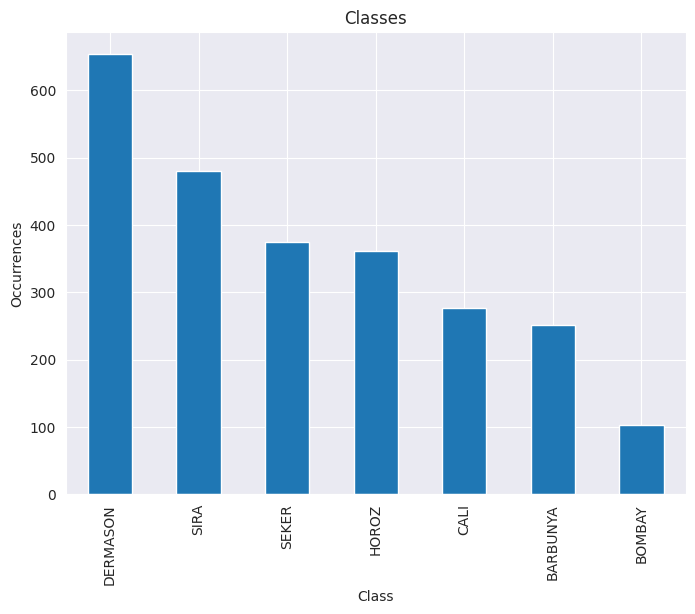

In [5]:
plt.figure(figsize=(8, 6))
y.value_counts().plot(kind='bar')
plt.title('Classes')
plt.xlabel('Class')
plt.ylabel('Occurrences')
plt.xticks(rotation=90)
plt.show()

Также заметим, что классы имеют строковые имена, закодируем их числами.

In [6]:
y = LabelEncoder().fit_transform(y)

Заметим, что есть много сильно коррелирующих признаков.

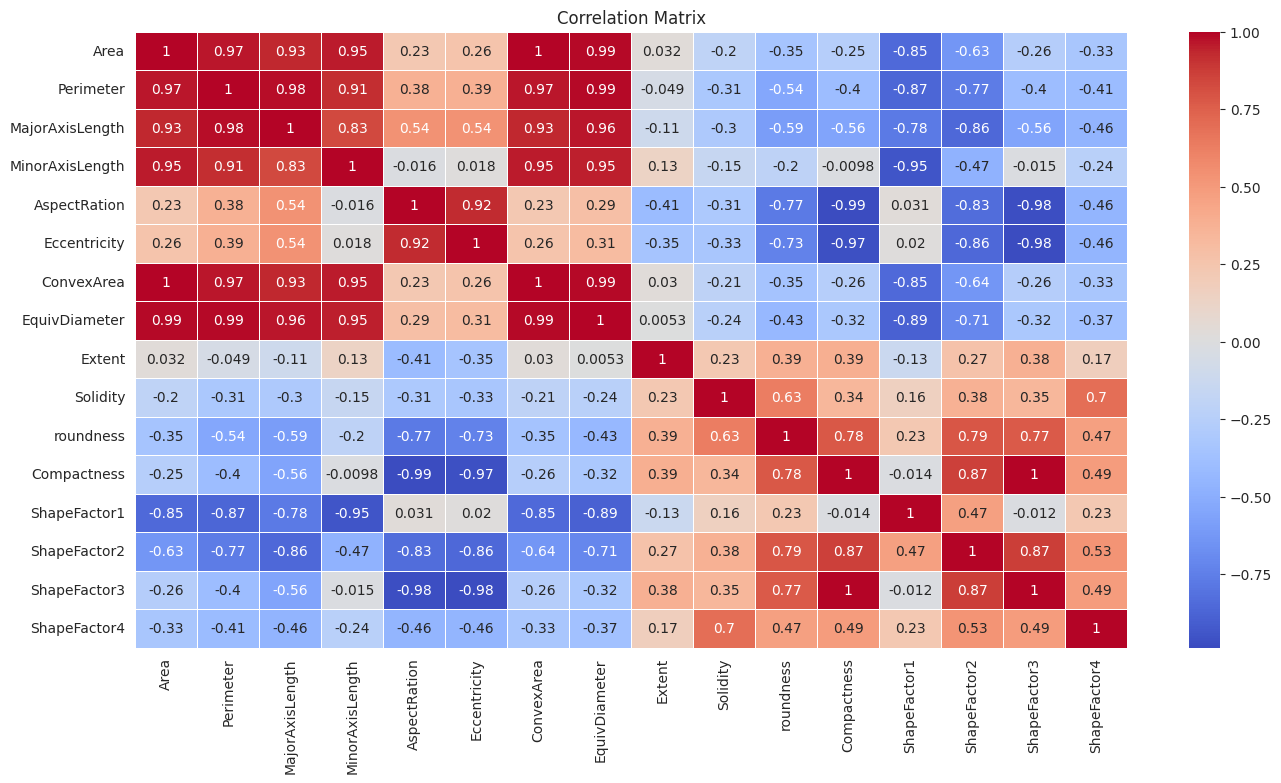

In [7]:
correlation_matrix = X.corr()
plt.figure(figsize=(16, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

Удалим признаки `ConvexArea` и `EquivDiameter`, так как они означают то же самое, что и `Area`, но, возможно, с немного другой точностью. Также удалим признак `Compactness` очень сильно коррелирующий (коэффициент корреляции `-0.99`) с `AspectRation`. Удалим признаки `MajorAxisLength` и `MinorAxisLength`, так они восстанавливаются из `Area` и `AspectRation` и очень сильно коррелируют с `Area`.

Заменим `Perimeter` на `Perimeter / sqrt(Area)`, чтобы понизить корреляцию этого признака с `Area`.

In [8]:
X = X.drop(columns=['ConvexArea', 'EquivDiameter', 'Compactness', 'MajorAxisLength', 'MinorAxisLength'])
X['RelativePerimeter'] = X['Perimeter'] / np.sqrt(X['Area'])
X = X.drop(columns=['Perimeter'])

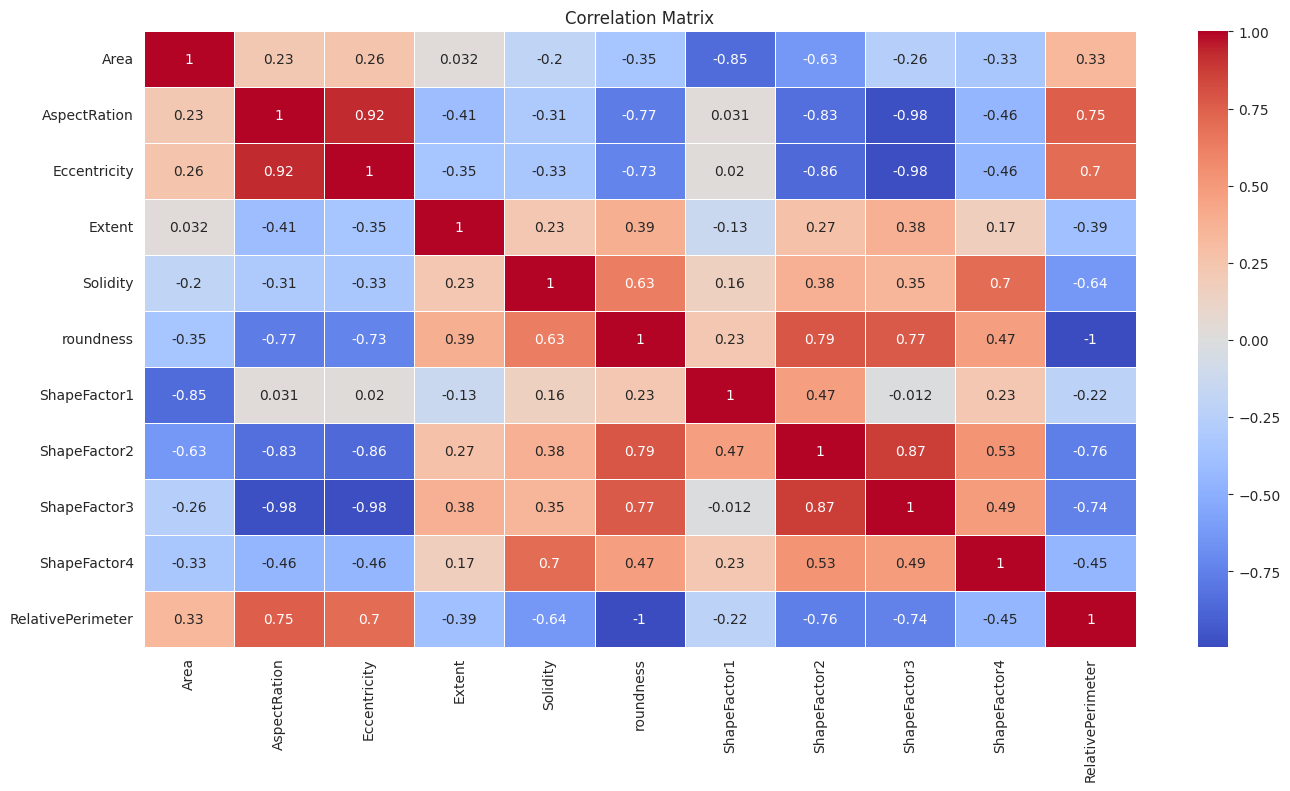

In [9]:
correlation_matrix = X.corr()
plt.figure(figsize=(16, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

Заметим, что новый признак `RelativePerimeter` дублирует уже существующий признак `roundness`, поэтому удалим его. Также удалим признаки `Eccentricity` и `AspectRation`, сильно коррелирующие с `ShapeFactor3`.

In [10]:
X = X.drop(columns=['AspectRation', 'Eccentricity', 'RelativePerimeter'])

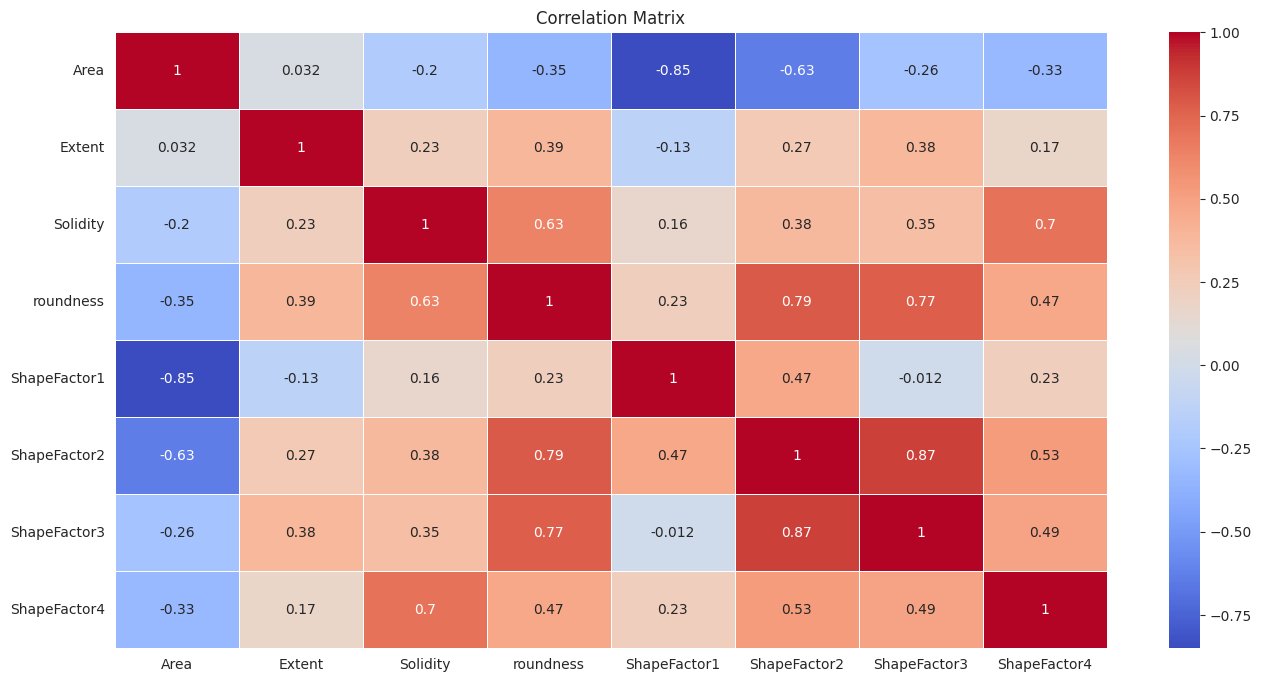

In [11]:
correlation_matrix = X.corr()
plt.figure(figsize=(16, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

Заметим, что распределение значений признаков не является нормальным, поэтому будем использовать `RobustScaler`.

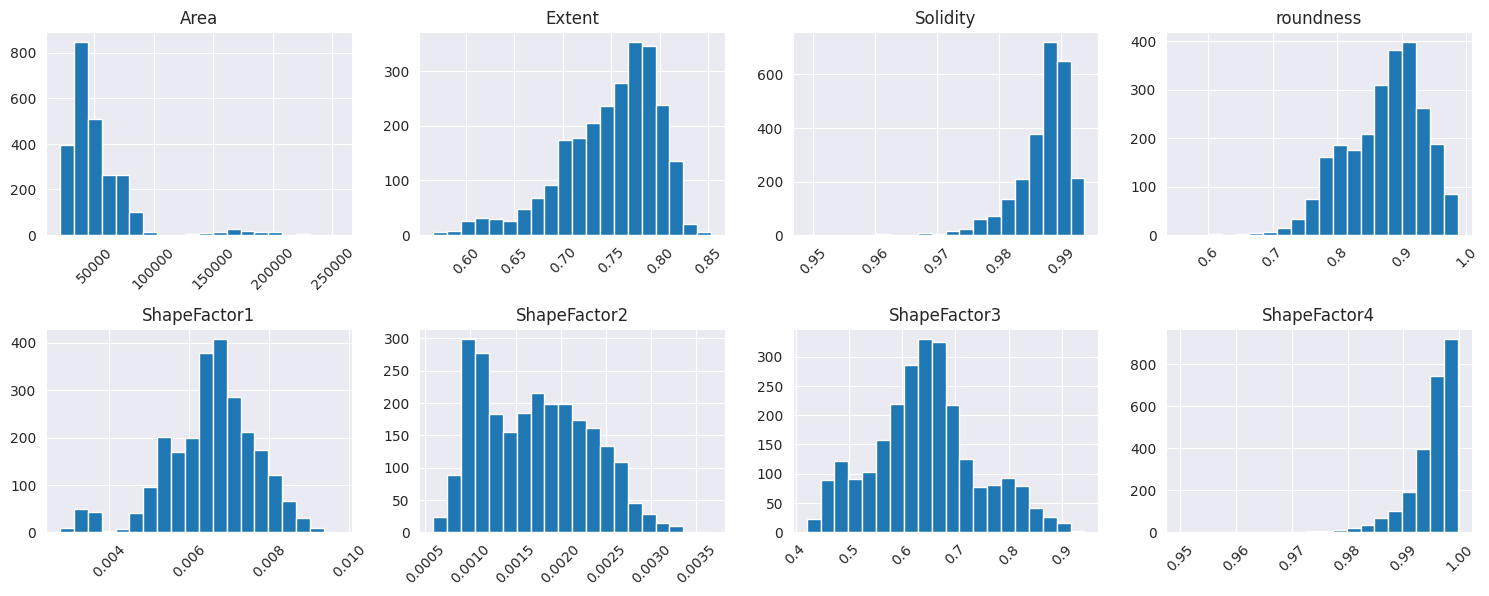

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))
axes = axes.ravel()

for idx, col in enumerate(X.columns):
    X[col].plot(kind='hist', ax=axes[idx], title=col, bins=20)
    axes[idx].tick_params(axis='x', labelrotation=45)
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')

plt.tight_layout()
plt.show()

## Оборудование (для воспроизведения замеров по времени)

In [13]:
!printf '========== OS  ==========\n'
!grep '^NAME=' /etc/os-release
!grep '^VERSION=' /etc/os-release

!printf '\n========== CPU ==========\n'
!lscpu | grep -E 'Architecture|Model name|Threads|Cores|MHz'

!printf '\n========== GPU ==========\n'
!nvidia-smi -L | grep -o 'NVIDIA .* (' | sed 's/ (//'
!nvidia-smi | grep -o 'CUDA Version: [0-9.]*'
!nvidia-smi --query-gpu=memory.total --format=csv | grep '[0-9]* MiB'

!printf '\n========== RAM ==========\n'
!free -m

========== OS  ==========
NAME="Ubuntu"
VERSION="22.04.3 LTS (Jammy Jellyfish)"

========== CPU ==========
Architecture:                       x86_64
Model name:                         12th Gen Intel(R) Core(TM) i5-12500H
CPU max MHz:                        4500.0000
CPU min MHz:                        400.0000

========== GPU ==========
NVIDIA GeForce RTX 3050 Laptop GPU
CUDA Version: 12.0
4096 MiB

========== RAM ==========
               total        used        free      shared  buff/cache   available
Mem:           15687        5474        4449         878        5764        8994
Swap:          11718          92       11626


## Сравнение методов многоклассовой классификации

Разобьём случайным образом данные на обучающую и тестовую выборки, сохраняя пропорции классов.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

Закодируем `y_test` с помощью `OneHotEncoder`, потому что в `roc_auc_score` ожидает вход в таком формате.

In [15]:
y_one_hot_encoder = OneHotEncoder(sparse_output=False, categories='auto')
y_test_proba = y_one_hot_encoder.fit_transform(y_test.reshape(-1, 1))

Выберем алгоритмы классификации, сетки подбора гиперпараметров и стратегии многоклассовой классификации. 

In [16]:
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier()
}

param_grids = {
    "Logistic Regression": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    },
    "SVM": {
        "C": [0.01, 0.1, 1, 10, 100],
        "gamma": [0.001, 0.01, 0.1, 1, 10],
        "kernel": ["linear", "rbf"]
    },
    "KNN": {
        "n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan", "minkowski"]
    },
    "Naive Bayes": {},
    "Decision Tree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [None, 3, 5, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    }
}


multiclass_strategies = {
    "OneVsRest": OneVsRestClassifier,
    "OneVsOne": OneVsOneClassifier,
    "OutputCode": OutputCodeClassifier
}

Реализуем функцию обучения и оценки качества, для стратегии `OneVsRest` будем получать результаты с помощью метода `predict_proba`, для остальных же стратегий из-за отсутствия метода `predict_proba` будем использовать метод `predict` в сочетании с `OneHotEncoder`.

In [17]:
def train_and_evaluate(classifier_name, multiclass_strategy):
    estimator = multiclass_strategies[multiclass_strategy](classifiers[classifier_name])
    pipeline = Pipeline([("scaler", RobustScaler()), ("estimator", estimator)])

    param_grid = {f"estimator__estimator__{param}": values for param, values in param_grids[classifier_name].items()}
        
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
        
    grid_search.fit(X_train, y_train)
    
    if multiclass_strategy == "OneVsRest":
        y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)
        if classifier_name == "Decision Tree":
            # decision trees sometimes assign NaN probability, 
            # replace NaNs to avoid roc_auc_score failure
            y_pred_proba = np.nan_to_num(y_pred_proba, nan=1 / y_pred_proba.shape[1])
    else:
        # fallback to one hot encoded predict when there's no predict_proba
        y_pred = grid_search.predict(X_test)
        y_pred_proba = y_one_hot_encoder.transform(y_pred.reshape(-1, 1))
    
    return grid_search.refit_time_, roc_auc_score(y_test_proba, y_pred_proba, multi_class='ovo', average='macro')

Отобразим полученные результаты

In [18]:
results = []

for classifier_name in classifiers:
    for multiclass_strategy in multiclass_strategies:
        training_time, auc_score = train_and_evaluate(classifier_name, multiclass_strategy)
        results.append({
            "Classifier": classifier_name,
            "Multiclass strategy": multiclass_strategy,
            "Training Time, s": training_time,
            "AUC Score": auc_score,
        })

results_df = pd.DataFrame(results)

pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.3f}'.format)

results_df.sort_values('AUC Score', ascending=False)

,Classifier,Multiclass strategy,"Training Time, s",AUC Score
3,SVM,OneVsRest,0.302,0.995
0,Logistic Regression,OneVsRest,0.056,0.993
9,Naive Bayes,OneVsRest,0.008,0.989
6,KNN,OneVsRest,0.011,0.988
12,Decision Tree,OneVsRest,0.053,0.965
4,SVM,OneVsOne,0.091,0.961
5,SVM,OutputCode,0.578,0.959
1,Logistic Regression,OneVsOne,0.042,0.958
7,KNN,OneVsOne,0.023,0.958
8,KNN,OutputCode,0.014,0.957


## Выводы

Все рассмотренные комбинации моделей и стратегий показали высокие значения `ROC-AUC` (больше `0.85`), что означает, что данная задача классификации кофейных зёрен достаточно простая. Стоит отметить, что `OneVsRest` стратегия в сочетании с любым видом моделей показала результаты (по `ROC-AUC`) лучше, чем любая комбинация других стратегий с любыми моделями. Самое высокое значение `ROC-AUC` (`0.995`) было получено при использовании `SVM` модели и `OneVsRest` стратегии.

Что касается времени обучения (без учёта подбора гиперпараметров), лучшие результаты показала `Naive Bayes` модель. Стоит отметить, что комбинация `Naive Bayes` и `OneVsRest` показала выдающиеся результаты как по времени обучения (первое место), так и по `ROC-AUC` (третье место), что довольно примечательно, учитывая достаточно высокую корреляцию нецелевых признаков даже после сокращения их числа.